In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 # Import dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Github Projects/House Price Prediction-Zoopla/preprocessed_zoopla.csv"
df = pd.read_csv(file_path)

# 1. Final pre-processing

In [4]:
df.head()

,rooms,isRetirementHome,isSharedOwnership,listingCondition,numBaths,numRecepts,MetBoroughs,propertyGroup,tenure,ditsnace_to_school,ditsnace_to_train,price
0,3,False,False,pre-owned,1,1,Leeds,House,freehold,0.1,1.2,290000
1,1,False,False,pre-owned,1,1,Leeds,House,freehold,0.4,0.5,160000
2,4,False,False,pre-owned,3,2,Kirklees,House,freehold,0.3,0.3,295000
3,2,False,False,pre-owned,1,1,Leeds,House,leasehold,0.1,0.2,235000
4,5,False,False,pre-owned,4,5,Leeds,House,freehold,0.1,0.3,350000


In [6]:
#  Define Features and Target
X = df.drop(columns='price')  # Features
y = df['price']               # Target

In [7]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Identifying column types:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [9]:
# Define transformers for scaling numerical variables and encoding categorical variables:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Modelling

## Define Pipelines for Each Model

In [12]:
from sklearn.pipeline import Pipeline

### Linear Regression

In [13]:
linreg_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

### Random Forest

In [14]:
rf_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

### XGBoost

In [15]:
xgb_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

In [23]:
# Evaluation function
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE:  {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R2:   {r2:.4f}")

    return r2, rmse, mae


In [24]:
print("Linear Regression:")
r2, rmse, mae = evaluate(linreg_model, X_train, X_test, y_train, y_test)

print("\nRandom Forest:")
r2_rf, rmse_rf, mae_rf = evaluate(rf_model, X_train, X_test, y_train, y_test)

print("\nXGBoost:")
r2_xgb, rmse_xgb, mae_xgb = evaluate(xgb_model, X_train, X_test, y_train, y_test)


Linear Regression:
MAE:  78,358.32
RMSE: 125,865.79
R2:   0.5909

Random Forest:
MAE:  71,710.65
RMSE: 115,890.71
R2:   0.6532

XGBoost:
MAE:  68,932.07
RMSE: 112,748.81
R2:   0.6718


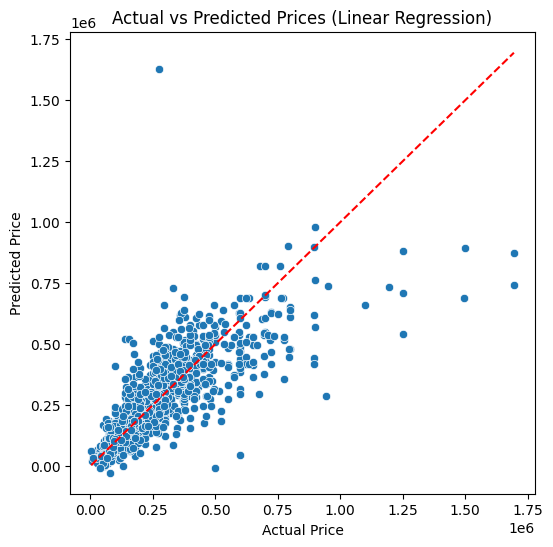

In [20]:
# visualise actual vs. predicted values Linear Regression
y_pred = linreg_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Linear Regression)')
plt.show()

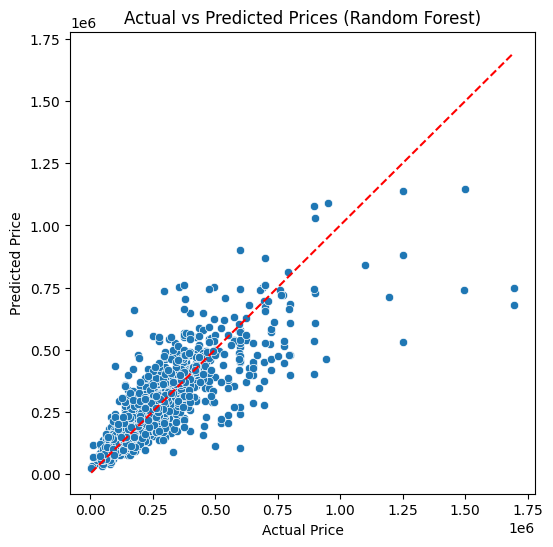

In [19]:
# Visualise actual vs. predicted values Random Forest
y_pred_rf = rf_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Random Forest)')
plt.show()

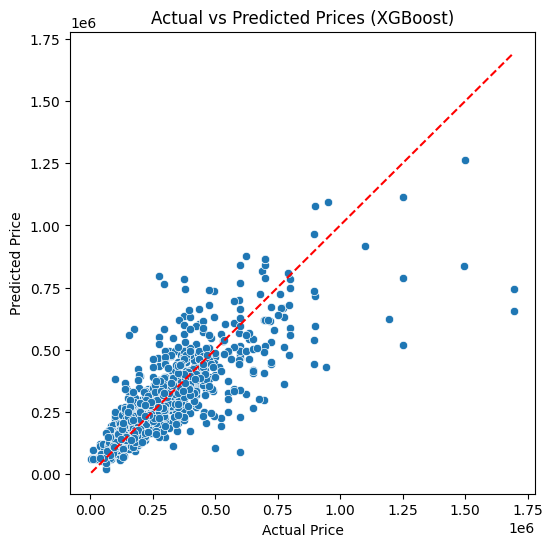

In [21]:
# Visualise actual vs. predicted values for XGBoost
y_pred_xgb = xgb_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.show()

In [25]:
metrics_dict = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared': [r2, r2_rf, r2_xgb],
    'RMSE': [rmse, rmse_rf, rmse_xgb],
    'MAE': [mae, mae_rf, mae_xgb]
}

metrics_df = pd.DataFrame(metrics_dict)
print("Model comparison before hyperparameter tuning:")
print(metrics_df)


Model comparison before hyperparameter tuning:
               Model  R-squared           RMSE           MAE
0  Linear Regression   0.590935  125865.791374  78358.320411
1      Random Forest   0.653204  115890.705018  71710.649869
2            XGBoost   0.671753  112748.806539  68932.070312


# Feature Importances

In [27]:
# Get feature names from preprocessing pipeline
onehot_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_features = numerical_features + onehot_columns


### Get Feature Importances from Model

In [28]:
# For Random Forest
importances = rf_model.named_steps['regressor'].feature_importances_

In [29]:
# For XGBoost
importances = xgb_model.named_steps['regressor'].feature_importances_

### Create and Plot Feature Importance

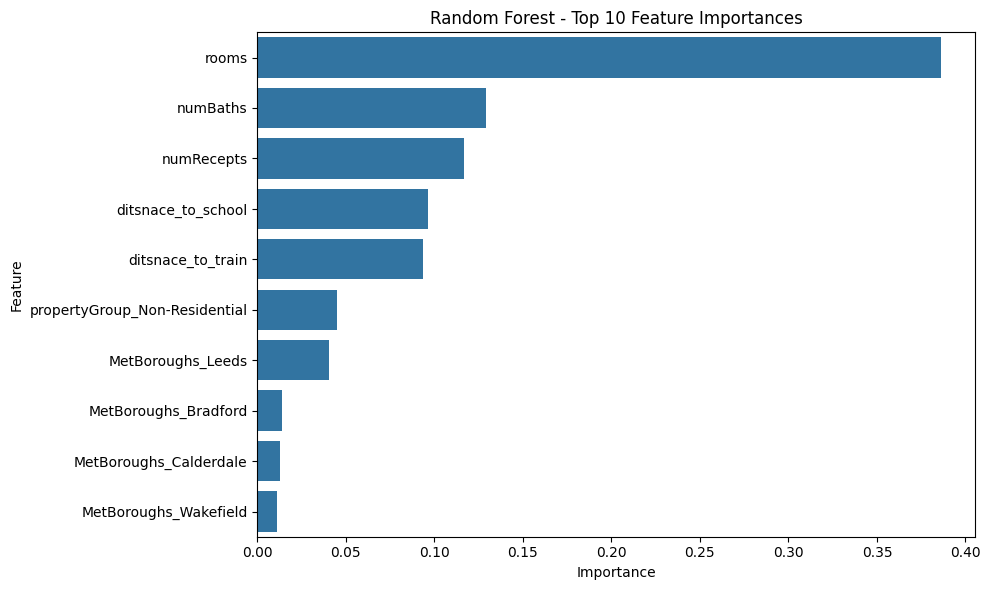

In [33]:
# Feature importance Random Forest
rf_importances = rf_model.named_steps['regressor'].feature_importances_
rf_df = pd.DataFrame({'Feature': all_features, 'Importance': rf_importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_df.head(10), x='Importance', y='Feature')
plt.title('Random Forest - Top 10 Feature Importances')
plt.tight_layout()
plt.show()

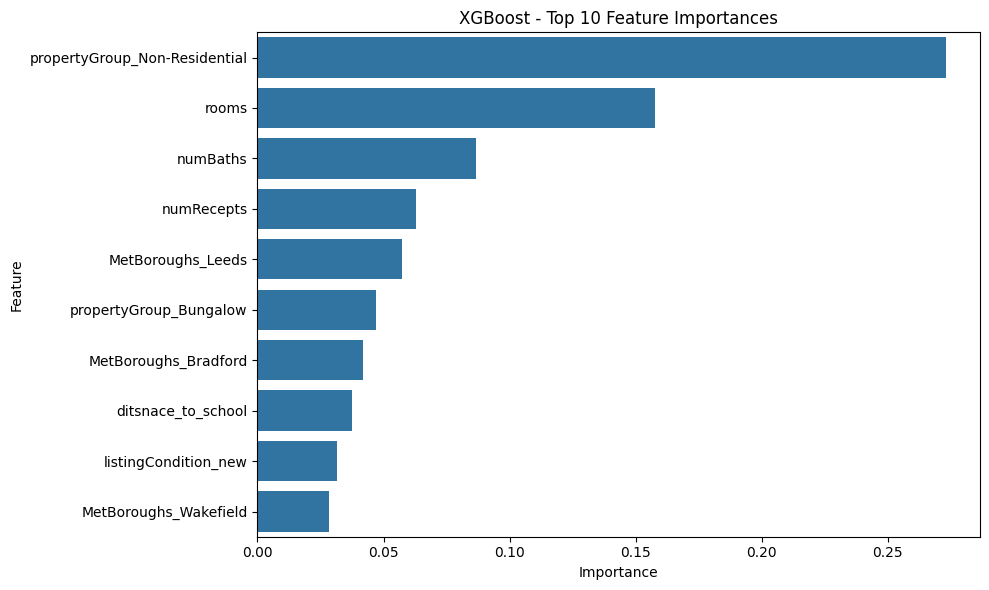

In [35]:
# Feature importance XGBoost
xgb_importances = xgb_model.named_steps['regressor'].feature_importances_
xgb_df = pd.DataFrame({'Feature': all_features, 'Importance': xgb_importances})
xgb_df = xgb_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_df.head(10), x='Importance', y='Feature')
plt.title('XGBoost - Top 10 Feature Importances')
plt.tight_layout()
plt.show()

Hyperparameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
# Tuning Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=rf_model,  # your pipeline
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)


Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}


In [38]:
# Tuning for XGBoost

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 9],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_root_mean_squared_error',  # or 'r2', etc.
    cv=5,
    verbose=1,
    n_jobs=-1
)


grid_search_xgb.fit(X_train, y_train)

print("Best parameters found for XGBoost:")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found for XGBoost:
{'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}


Re-training Models with best hyperparameters

In [39]:
# Retrain the models with the best hyperparameters

rf_model_best = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        random_state=42
    ))
])

rf_model_best.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['rooms', 'isRetirementHome',
                                                   'isSharedOwnership',
                                                   'numBaths', 'numRecepts',
                                                   'ditsnace_to_school',
                                                   'ditsnace_to_train']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['listingCondition',
                                                   'MetBoroughs',
                                                   'propertyGroup',
                                                   'tenure'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

In [40]:
from xgboost import XGBRegressor

xgb_model_best = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_model_best.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['rooms', 'isRetirementHome',
                                                   'isSharedOwnership',
                                                   'numBaths', 'numRecepts',
                                                   'ditsnace_to_school',
                                                   'ditsnace_to_train']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['listingCondition',
                                                   'MetBoroughs',
                                                   'propertyGroup',
                                                   'tenure'])])),
                ('regressor',
                 XGBRegressor(base_score...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

### Evaluate retrained models

In [43]:
# Random forest retrained
evaluate(rf_model_best, X_train, X_test, y_train, y_test)

MAE:  69,475.43
RMSE: 113,147.29
R2:   0.6694


(0.6694288301721638, np.float64(113147.2865372918), 69475.42844998416)

In [44]:
# XGBoost retrained
evaluate(xgb_model_best, X_train, X_test, y_train, y_test)

MAE:  69,492.34
RMSE: 116,241.06
R2:   0.6511


(0.6511041522026062, np.float64(116241.06042186642), 69492.34375)

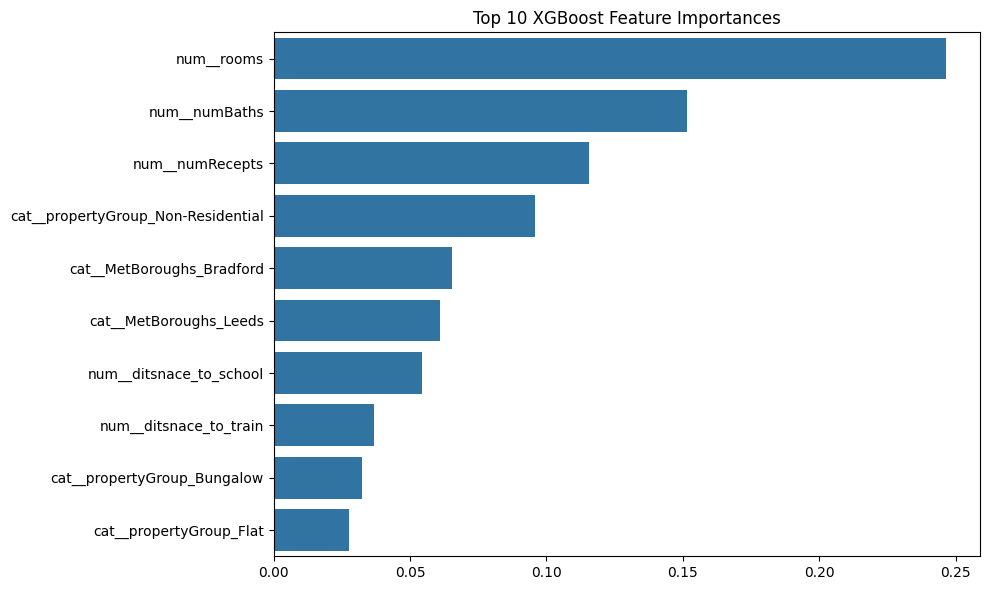

In [47]:
importances = xgb_model_best.named_steps['regressor'].feature_importances_
feature_names = xgb_model_best.named_steps['preprocessing'].get_feature_names_out()
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx][:10], y=feature_names[sorted_idx][:10])
plt.title("Top 10 XGBoost Feature Importances")
plt.tight_layout()
plt.show()
